In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Bidirectional, Input, Concatenate
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, Normalizer

Using TensorFlow backend.


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,84,94,110,110,120,170,174,237,273,281
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,146,174,186,197,212,223,243,259,277,304
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,302,367,409,454,511,584,716,847,986,1171
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,188,224,267,308,334,370,376,390,428,439
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,3,4,4,5,7,7,7,8,8,8


In [3]:
df = df.groupby(['Country/Region']).sum().reset_index(level=['Country/Region'])
dates = df.columns[4:]

df = df.melt(id_vars=[ 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')
df['Date'] =pd.to_datetime(df.Date)

df = df[df['Country/Region'] != 'China']
df_c = df

In [4]:
df_c.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [5]:
df = df.groupby('Date')['Confirmed'].sum().reset_index()
df['Day num'] = np.arange(1, len(df)+1)
# df['Population'] = np.array([6.4 *(10**9) for x in range(len(df))])

df.head()

,Date,Confirmed,Day num
0,2020-01-23,11,1
1,2020-01-24,21,2
2,2020-01-25,28,3
3,2020-01-26,43,4
4,2020-01-27,50,5


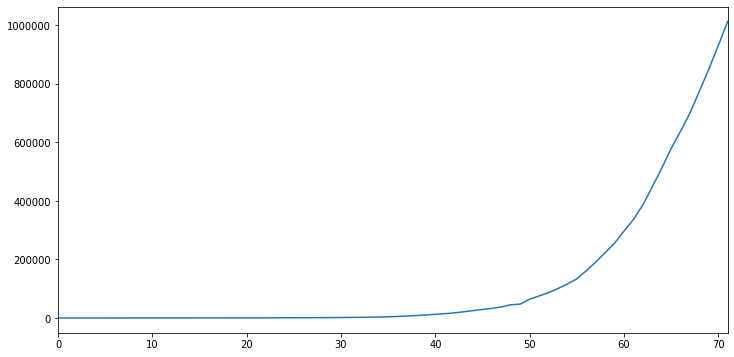

In [6]:
df['Confirmed'].plot(figsize=(12,6))

In [7]:
num_epochs = 200
batch_size = 32
split = 0.8
window = 18

In [8]:
training = split
total = df.shape[0]
train_index = int(total*training)

In [9]:
training_set = df[:train_index]

In [10]:
# sc = MinMaxScaler()
# sc = StandardScaler(with_mean=False)
sc = PowerTransformer(method='yeo-johnson', standardize=True)
# sc = Normalizer()
training_set_scaled = np.asarray(sc.fit_transform(pd.DataFrame(training_set[['Confirmed']]).values))

In [11]:

X_train = []
y_train = []
for i in range(window, train_index):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [12]:
print(X_train.shape, y_train.shape)

(39, 18, 1) (39,)


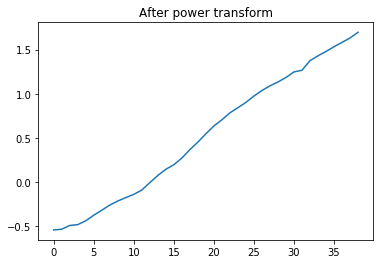

In [13]:
X_train[0]
plt.plot(y_train)
plt.title('After power transform')

plt.show()

In [14]:
testing_set = df[train_index:]
testing_set = pd.DataFrame(testing_set)
testing_set.head()

,Date,Confirmed,Day num
57,2020-03-20,190785,58
58,2020-03-21,223091,59
59,2020-03-22,255518,60
60,2020-03-23,296737,61
61,2020-03-24,336454,62


In [15]:
real_conf = testing_set['Confirmed'].values

In [16]:
test_set=testing_set['Confirmed']
test_set=pd.DataFrame(test_set)

In [17]:
inputs = df['Confirmed'][len(df) - len(testing_set) - window:].values
# print(inputs)
inputs = inputs.reshape(-1,1)
# print(inputs)
inputs = sc.transform(inputs)
# print(inputs)
X_test = []
for i in range(window, window+(total-train_index)):
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [18]:
# inputs
# total

In [19]:
Y_test = np.asarray(sc.transform(pd.DataFrame(testing_set['Confirmed']).reset_index(drop=True).values))

In [20]:
def root_mean_squared_logarithmic_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(K.log(y_pred + 1) - K.log(y_true + 1)))) 

In [21]:
model = Sequential()

model.add(LSTM(units = 256, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = root_mean_squared_logarithmic_error)

# population_input_layer = Input(shape=(1,))
# population_dense = Dense(32)(population_input_layer)

# input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
# lstm = LSTM(256)(input_layer)
# merge = Concatenate(axis=-1)([lstm,population_dense])
# dropout_lstm = Dropout(0.2)(merge)
# confirmed = Dense(1)(dropout_lstm)

# model = Model([input_layer,population_input_layer], confirmed)
# model.summary()

# model.compile(optimizer = 'adam', loss = root_mean_squared_logarithmic_error)


In [22]:
# early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='min')
plat = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.7)
cb = [checkpoint, plat]

In [23]:
history = model.fit(X_train, y_train, 
                    epochs = num_epochs, 
                    batch_size = batch_size, 
                    callbacks = cb,
#                     validation_data = (X_test, Y_test),
                    validation_split = 0.1)

Train on 35 samples, validate on 4 samples
Epoch 1/200
35/35 [==============================] - 1s 23ms/step - loss: 0.6558 - val_loss: 0.6783
Epoch 2/200
35/35 [==============================] - 0s 4ms/step - loss: 0.4540 - val_loss: 0.3890
Epoch 3/200
35/35 [==============================] - 0s 4ms/step - loss: 0.3185 - val_loss: 0.2718
Epoch 4/200
35/35 [==============================] - 0s 4ms/step - loss: 0.2452 - val_loss: 0.2203
Epoch 5/200
35/35 [==============================] - 0s 4ms/step - loss: 0.2073 - val_loss: 0.1013
Epoch 6/200
35/35 [==============================] - 0s 4ms/step - loss: 0.1398 - val_loss: 0.0642
Epoch 7/200
35/35 [==============================] - 0s 4ms/step - loss: 0.0831 - val_loss: 0.1640
Epoch 8/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0833 - val_loss: 0.1896
Epoch 9/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0848 - val_loss: 0.1713
Epoch 10/200
35/35 [==============================] - 0s 4ms/step

Epoch 71/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0629 - val_loss: 0.0256
Epoch 72/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0256

Epoch 00072: ReduceLROnPlateau reducing learning rate to 4.747560842588427e-06.
Epoch 73/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0413 - val_loss: 0.0255
Epoch 74/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0450 - val_loss: 0.0254
Epoch 75/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0538 - val_loss: 0.0253
Epoch 76/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0460 - val_loss: 0.0252

Epoch 00076: ReduceLROnPlateau reducing learning rate to 3.3232926853088427e-06.
Epoch 77/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0488 - val_loss: 0.0251
Epoch 78/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0560 - val_loss: 0.0251
Epoch 79/200
35/35 [=================

35/35 [==============================] - 0s 3ms/step - loss: 0.0511 - val_loss: 0.0225
Epoch 139/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0486 - val_loss: 0.0225
Epoch 140/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0225

Epoch 00140: ReduceLROnPlateau reducing learning rate to 1.1044275005644976e-08.
Epoch 141/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0473 - val_loss: 0.0225
Epoch 142/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0414 - val_loss: 0.0225
Epoch 143/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0546 - val_loss: 0.0225
Epoch 144/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0225

Epoch 00144: ReduceLROnPlateau reducing learning rate to 7.730992379606505e-09.
Epoch 145/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 0.0225
Epoch 146/200
35/35 [======================

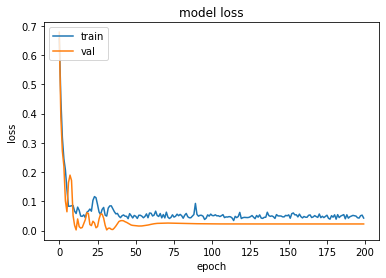

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [25]:
model.load_weights("model.h5")

In [26]:
predicted_conf = model.predict(X_test)

In [27]:
# predicted_conf=pd.DataFrame(predicted_conf)
X_test[0]

array([[0.70328353],
       [0.78231824],
       [0.84082398],
       [0.90101897],
       [0.97299126],
       [1.03582234],
       [1.08862387],
       [1.13247339],
       [1.18381686],
       [1.24676097],
       [1.26590085],
       [1.37430873],
       [1.42969739],
       [1.47930348],
       [1.53243373],
       [1.58270182],
       [1.632213  ],
       [1.69751689]])

In [28]:
sc.inverse_transform(predicted_conf)
# X_test
# X_train
# real_conf

array([[181733.78],
       [210630.86],
       [244245.94],
       [282658.53],
       [325710.66],
       [373136.72],
       [424553.12],
       [480829.28],
       [543117.06],
       [611480.2 ],
       [684471.75],
       [760087.9 ],
       [835691.56],
       [911940.1 ],
       [989042.3 ]], dtype=float32)

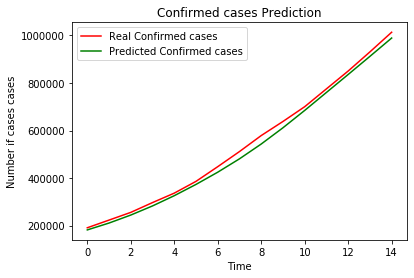

In [29]:
# plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(real_conf, color = 'red', label = 'Real Confirmed cases')
plt.plot(sc.inverse_transform(predicted_conf), color = 'green', label = 'Predicted Confirmed cases')
plt.title('Confirmed cases Prediction')
plt.xlabel('Time')
plt.ylabel('Number if cases cases')
plt.legend()
plt.show()

In [30]:
pred_conf = np.array(sc.inverse_transform(predicted_conf)).reshape(1,-1)[0]
real_conf = np.array(real_conf)
# pred_conf
real_conf

array([ 190785,  223091,  255518,  296737,  336454,  385992,  447809,
        511394,  578707,  637995,  700167,  775208,  850244,  930725,
       1013406], dtype=int64)

In [31]:

print("RMSLE = ", np.sqrt(np.mean(np.square(np.log(pred_conf + 1) - np.log(real_conf + 1)))))

RMSLE =  0.04238269915678641


# For each country

In [32]:
pop = pd.read_csv('datasets\population_data.csv')
pop.head()

,Name,Population,Type
0,Alabama,4888000.0,Province/State
1,Alaska,737438.0,Province/State
2,Alberta,4371000.0,Province/State
3,Anhui,62000000.0,Province/State
4,Arizona,7172000.0,Province/State


In [33]:
df_c.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [34]:
country ='Portugal'

In [35]:
temp = df_c[df_c['Country/Region'] == country]
temp = temp[temp['Confirmed'] > 0].fillna(0)
# temp = temp[temp['Confirmed'] > 0].diff().fillna(0)
temp.head()

,Country/Region,Lat,Long,Date,Confirmed
7194,Portugal,39.3999,-8.2245,2020-03-02,2
7375,Portugal,39.3999,-8.2245,2020-03-03,2
7556,Portugal,39.3999,-8.2245,2020-03-04,5
7737,Portugal,39.3999,-8.2245,2020-03-05,8
7918,Portugal,39.3999,-8.2245,2020-03-06,13


In [36]:
N = int(pop[pop['Name'] == country]['Population'])
N

10196709